### 기본 Search Tool graph

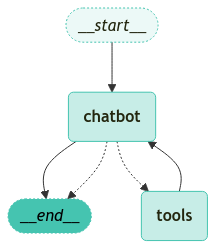

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_teddynote.tools.tavily import TavilySearch
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
tool = TavilySearch(max_results=3)
# 도구 목록 정의
tools = [tool]

# LLM 초기화
llm = ChatOllama(model="llama3.1:8b")
# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# 상태 그래프 생성
graph_builder = StateGraph(State)
# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=tools)
# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########
# tools > chatbot
graph_builder.add_edge("tools", "chatbot")
# START > chatbot
graph_builder.add_edge(START, "chatbot")
# chatbot > END
graph_builder.add_edge("chatbot", END)

########## 5. 그래프 컴파일 ##########
# 메모리 저장소 초기화
memory = MemorySaver()
# 그래프 빌더 컴파일
graph = graph_builder.compile(checkpointer=memory)

########## 6. 그래프 시각화 ##########
# 그래프 시각화
visualize_graph(graph)


### 1. 중간 단계의 상태(State) 수동 업데이트

##### 특정 단계 메세지 수정하기

In [2]:
from langchain_core.runnables import RunnableConfig

# 질문
question = "LangGraph 가 무엇인지 조사하여 알려주세요!"

# 초기 입력 상태를 정의
input = State(messages=[("user", question)])

# config 설정
config = RunnableConfig(
    configurable={"thread_id": "1"},  # 스레드 ID 설정
)

* 우선 채널목록을 출력하여 `interrupt_before` 와 `interrupt_after` 를 적용할 수 있는 목록을 출력합니다.

In [3]:
# 그래프 채널 목록 출력
list(graph.channels)

['messages',
 '__start__',
 'chatbot',
 'tools',
 'branch:__start__:__self__:chatbot',
 'branch:__start__:__self__:tools',
 'branch:chatbot:__self__:chatbot',
 'branch:chatbot:__self__:tools',
 'branch:tools:__self__:chatbot',
 'branch:tools:__self__:tools',
 'start:chatbot',
 'branch:chatbot:tools_condition:tools']

In [4]:
# 그래프 스트림 호출
events = graph.stream(
    input=input, config=config, interrupt_before=["tools"], stream_mode="values"
)

# 이벤트 반복 처리
for event in events:
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================ Human Message =================================

LangGraph 가 무엇인지 조사하여 알려주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (3f812c63-cc68-46fd-8ae4-6bbbaf2fd904)
 Call ID: 3f812c63-cc68-46fd-8ae4-6bbbaf2fd904
  Args:
    query: LangGraph


In [5]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 가장 최근 메시지 추출
last_message = snapshot.values["messages"][-1]

# 메시지 출력
last_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (3f812c63-cc68-46fd-8ae4-6bbbaf2fd904)
 Call ID: 3f812c63-cc68-46fd-8ae4-6bbbaf2fd904
  Args:
    query: LangGraph


In [6]:
modified_search_result = """[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요."""

print(modified_search_result)

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.


In [7]:
# 수정하고자 하는 `ToolMessage` 의 `tool_call_id` 추출
tool_call_id = last_message.tool_calls[0]["id"]
print(tool_call_id)

3f812c63-cc68-46fd-8ae4-6bbbaf2fd904


In [8]:
from langchain_core.messages import AIMessage, ToolMessage

new_messages = [
    # LLM API의 도구 호출과 일치하는 ToolMessage 필요
    ToolMessage(
        content=modified_search_result,
        tool_call_id=tool_call_id,
    ),
    # LLM의 응답에 직접적으로 내용 추가
    # AIMessage(content=modified_search_result),
]

new_messages[-1].pretty_print()

================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.


##### StateGraph의 update_state 메서드

In [33]:
# 노드 메세지가 어떻게 쌓이고 있는지 체크하기위한 함수.
from utils import check_state

In [10]:
graph.update_state(
    # 업데이트할 상태 지정
    config,
    # 제공할 업데이트된 값. `State`의 메시지는 "추가 전용"으로 기존 상태에 추가됨
    {"messages": new_messages},
    as_node="tools",
)

print("(최근 1개의 메시지 출력)\n")
print(graph.get_state(config).values["messages"][-1])

(최근 1개의 메시지 출력)

content='[수정된 웹 검색 결과] \nLangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.\nLangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.\n\n자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과\n테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.' id='7f217e4d-7709-4e66-a38c-e0be16da813c' tool_call_id='3f812c63-cc68-46fd-8ae4-6bbbaf2fd904'


In [11]:
snapshot = graph.get_state(config)
snapshot.next

('chatbot',)

In [12]:
# `None`는 현재 상태에 아무것도 추가하지 않음
# thread_id = 1
# 그래프 중단지점부터 재시작 
events = graph.stream(None, config, stream_mode="values")

# 이벤트 반복 처리
for event in events:
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.
================================== Ai Message ==================================

LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM(대규모 언어 모델)을 활용해 구축할 수 있도록 지원하는 오픈 소스 라이브러리입니다. LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공합니다. LangGraph의 자세한 튜토리얼은 공식 홈페이지와 TeddyNote의 한국어 튜토리얼에서 확인할 수 있습니다.


In [13]:
# 그래프 상태 스냅샷 생성
# thread_id = 1
snapshot = graph.get_state(config)

# 최근 세 개의 메시지 출력
for message in snapshot.values["messages"]:
    message.pretty_print()


================================ Human Message =================================

LangGraph 가 무엇인지 조사하여 알려주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (3f812c63-cc68-46fd-8ae4-6bbbaf2fd904)
 Call ID: 3f812c63-cc68-46fd-8ae4-6bbbaf2fd904
  Args:
    query: LangGraph
================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.
================================== Ai Message ==================================

LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM(대규모 언어 모델)을 활용해 구축할 수 있도록 지원하는 오픈 소스 라이브러리입니다. LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공합니다. LangGraph의 자세한 튜토리얼은 공식 홈페이지와 TeddyNote의 한국어 튜토리얼에서 확인할 수 있습니다.


In [14]:
# 이 함수가 작동할 노드 지정. 이 노드가 방금 실행된 것처럼 자동으로 처리 계속
# thread_id = 1
graph.update_state(
    config,
    {
        "messages": [
            AIMessage(content="마지막으로 최종 메시지를 추가하여 마무리 합니다.")
        ]
    },
    as_node="chatbot",
)


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe50dc-7a2b-6d3a-8004-5a6b542e2e76'}}

In [15]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 최근 세 개의 메시지 출력
for message in snapshot.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

LangGraph 가 무엇인지 조사하여 알려주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (3f812c63-cc68-46fd-8ae4-6bbbaf2fd904)
 Call ID: 3f812c63-cc68-46fd-8ae4-6bbbaf2fd904
  Args:
    query: LangGraph
================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.
================================== Ai Message ==================================

LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM(대규모 언어 모델)을 활용해 구축할 수 있도록 지원하는 오픈 소스 라이브러리입니다. LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공합니다. LangGraph의 자세한 튜토리얼은 공식 홈페이지와 TeddyNote의 한국어 튜토리얼에서 확인할 수 있습니다.
===================

In [16]:
# 다음 상태 출력
print(snapshot.next)

()


In [17]:
# ---------- 상태 체크 ---------- #
# 상태 기록 가져오기
check_state(graph, config)


dd7cac91-af41-4af2-9cae-4eba8767fa68
메시지 수:  5 다음 노드:  ()
--------------------------------------------------------------------------------
run-7dc0aabc-78bf-4673-922d-a987f523a343-0
메시지 수:  4 다음 노드:  ()
--------------------------------------------------------------------------------
7f217e4d-7709-4e66-a38c-e0be16da813c
메시지 수:  3 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
run-cb1ef320-c55c-415a-b6cd-ccc861167e31-0
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
ab7d964d-c8dd-4731-97a5-053d187b370b
메시지 수:  1 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------


### 2. Interrupt 후 메시지 상태 업데이트 - 이어서 진행

In [18]:
from langchain_teddynote.graphs import generate_random_hash

# 같은 graph(1번에서 다 돌고 끝난 그래프)에 새로운 thread_id로 시작.
thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

question = "LangGraph 에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!"

# 초기 입력 상태를 정의
input = State(messages=[("user", question)])

# 새로운 config 생성
config = {"configurable": {"thread_id": thread_id}}

events = graph.stream(
    input=input,
    config=config,
    interrupt_before=["tools"],
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

thread_id: df588e
================================ Human Message =================================

LangGraph 에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (3b94da34-1a58-4af1-a507-60d2fe2c6e55)
 Call ID: 3b94da34-1a58-4af1-a507-60d2fe2c6e55
  Args:
    query: LangGraph 관련된자료


In [19]:
from langchain_core.messages import AIMessage

# 스냅샷 상태 가져오기
snapshot = graph.get_state(config)
# messages 의 마지막 메시지 가져오기
existing_message = snapshot.values["messages"][-1]

# 메시지 ID 출력
print("Message ID", existing_message.id)

Message ID run-60047d7d-8652-4e40-bf9a-3783caaeb9d2-0


In [22]:
# ---------- 상태 체크 ---------- #
# 상태 기록 가져오기
check_state(graph, config)


run-60047d7d-8652-4e40-bf9a-3783caaeb9d2-0
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
53884b1b-26ac-4411-a9dd-037d68163c65
메시지 수:  1 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------


In [23]:
# 첫 번째 도구 호출 출력
print(existing_message.tool_calls[0])

{'name': 'tavily_web_search', 'args': {'query': 'LangGraph 관련된자료'}, 'id': '3b94da34-1a58-4af1-a507-60d2fe2c6e55', 'type': 'tool_call'}


In [24]:
# tool_calls 를 복사하여 새로운 도구 호출 생성
new_tool_call = existing_message.tool_calls[0].copy()

# 쿼리 매개변수 업데이트(갱신)
new_tool_call["args"] = {"query": "LangGraph site:teddylee777.github.io"}
new_tool_call

{'name': 'tavily_web_search',
 'args': {'query': 'LangGraph site:teddylee777.github.io'},
 'id': '3b94da34-1a58-4af1-a507-60d2fe2c6e55',
 'type': 'tool_call'}

In [25]:
# AIMessage 생성
new_message = AIMessage(
    content=existing_message.content, # 원래 비어있었지만, 암튼 기존꺼 그대로 넣어줌.
    tool_calls=[new_tool_call],
    # 중요! ID는 메시지를 상태에 추가하는 대신 교체하는 방법
    id=existing_message.id,
)

print(new_message.id)

# 수정한 메시지 출력
new_message.pretty_print()

run-60047d7d-8652-4e40-bf9a-3783caaeb9d2-0
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (3b94da34-1a58-4af1-a507-60d2fe2c6e55)
 Call ID: 3b94da34-1a58-4af1-a507-60d2fe2c6e55
  Args:
    query: LangGraph site:teddylee777.github.io


In [26]:
# 업데이트된 도구 호출 출력
print(new_message.tool_calls[0])
# 메시지 ID 출력
print("\nMessage ID", new_message.id)

# 상태 업데이트
# thread_id: df588e
graph.update_state(config, {"messages": [new_message]})

{'name': 'tavily_web_search', 'args': {'query': 'LangGraph site:teddylee777.github.io'}, 'id': '3b94da34-1a58-4af1-a507-60d2fe2c6e55', 'type': 'tool_call'}

Message ID run-60047d7d-8652-4e40-bf9a-3783caaeb9d2-0


{'configurable': {'thread_id': 'df588e',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe50f2-2dab-6ce2-8002-ecadace9d953'}}

In [27]:
# 마지막 메시지의 도구 호출 가져오기
# 업데이트 잘 됐는지 확인
graph.get_state(config).values["messages"][-1].tool_calls

[{'name': 'tavily_web_search',
  'args': {'query': 'LangGraph site:teddylee777.github.io'},
  'id': '3b94da34-1a58-4af1-a507-60d2fe2c6e55',
  'type': 'tool_call'}]

In [28]:
# ---------- 상태 체크 ---------- #
# 상태 기록 가져오기
check_state(graph, config)


run-60047d7d-8652-4e40-bf9a-3783caaeb9d2-0
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
run-60047d7d-8652-4e40-bf9a-3783caaeb9d2-0
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
53884b1b-26ac-4411-a9dd-037d68163c65
메시지 수:  1 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------


In [29]:
# 그래프 스트림에서 이벤트 수신
# 다시 그래프 시작하기. 
# thread_id: df588e
events = graph.stream(None, config, stream_mode="values")

# 각 이벤트에 대한 처리
for event in events:
    # 메시지가 있는 경우 마지막 메시지 출력
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (3b94da34-1a58-4af1-a507-60d2fe2c6e55)
 Call ID: 3b94da34-1a58-4af1-a507-60d2fe2c6e55
  Args:
    query: LangGraph site:teddylee777.github.io
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "LangGraph - Multi-Agent Collaboration (다중 협업 ... - 테디노트", "url": "https://teddylee777.github.io/langgraph/langgraph-multi-agent-collaboration/", "content": "LangGraph - Multi-Agent Collaboration (다중 협업 에이전트) 로 복잡한 테스크를 수행하는 LLM 어플리케이션 제작 LangChain 에서 야심차게 LangGraph 를 새롭게 출시하였습니다.", "score": 0.4031679, "raw_content": "🔥알림🔥\n① 테디노트 유튜브 -\n구경하러 가기!\n② LangChain 한국어 튜토리얼\n바로가기 👀\n③ 랭체인 노트 무료 전자책(wikidocs)\n바로가기 🙌\n④ RAG 비법노트 LangChain 강의오픈\n바로가기 🙌\n⑤ 서울대 PyTorch 딥러닝 강의\n바로가기 🙌\nLangGraph - Multi-Agent Collaboration(다중 협업 에이전트) 로 복잡한 테스크를 수행하는 LLM 어플리케이션 제작\n2024년 01월 29일\n26 분 소요\nLangChain 에서 야심차게 LangGraph 를 새롭게 출시하였습니다. 

In [32]:
from utils import check_state

# thread_id: df588e
check_state(graph, config)


run-159914be-d6ff-422d-94a9-76e0deb58368-0
메시지 수:  4 다음 노드:  ()
--------------------------------------------------------------------------------
dac299d7-8277-483e-b94d-2639abb385cf
메시지 수:  3 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
run-60047d7d-8652-4e40-bf9a-3783caaeb9d2-0
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
run-60047d7d-8652-4e40-bf9a-3783caaeb9d2-0
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
53884b1b-26ac-4411-a9dd-037d68163c65
메시지 수:  1 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------


In [34]:
# 새로운 메세지를 넣어서 다시 graph 시작 
# 이벤트 스트림 생성
# thread_id: df588e
events = graph.stream(
    {
        "messages": (
            "user",
            "내가 지금까지 배운 내용에 대해서 매우 친절하고 정성스럽게 한국어로 답변해줘! 출처를 반드시 포함해줘!",
            # 테디형이 이렇게 다시 질문을 해서 다시 graph를 시작하는 의도는,
            # 앞에 query를 수정한 결과로 배운 대화를 이 config가 해당하는 thread_id의 checkpointer를 가지고
            # 기억을 하고 있기 때문에, 그 기억을 반영해서 챗봇이 출처까지 넣어서 답변하는 것을 보여주기 위해서다.
            # 하지만 Ollama llama3.1:8b 모델을 사용한다면 챗봇이 tool_call을 하면서 
            # 이 부분에서 멍청하게 Query를 넣어서 멍청한 답변을 하고 있을 가능성이 커서 
            # 테디형이 의도한대로 동작은 못하지만.. 아무튼 의도는 그렇다. 
        )
    },
    config,
    stream_mode="values",
)

# 메시지 이벤트 처리
for event in events:
    if "messages" in event:
        # 마지막 메시지 출력
        event["messages"][-1].pretty_print()

================================ Human Message =================================

내가 지금까지 배운 내용에 대해서 매우 친절하고 정성스럽게 한국어로 답변해줘! 출처를 반드시 포함해줘!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (d097b3e7-1b3c-4fe8-bd8e-4f0f4330b42e)
 Call ID: d097b3e7-1b3c-4fe8-bd8e-4f0f4330b42e
  Args:
    query: 총되일 나세요 횏로해유다장 주속하세요
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "韓語祝賀語指南：掌握韓文祝福，開啟人際關係新篇章 | 姜允熙韓語教室", "url": "https://koreantalker.cc/祝賀-韓文", "content": "韓文筆記：新年祝賀語與其他常用祝賀語 隨著新年的到來，您是否希望以最地道的韓文向親朋好友獻上祝福？掌握韓文祝賀語不僅能展現您的語言能力，還能縮短與韓國朋友、同事或客戶之間的距離，開啟人際關係的新篇章。 我們從最常見的新年祝賀語入手。在韓國，通常會使用「새해 복 많이", "score": 0.101456024, "raw_content": null}, {"title": "김영철, 타일러의 진짜 미국식 영어 - 표현 정리 1-5회", "url": "https://agitate.tistory.com/249", "content": "출처: SBS 김영철의 파워 FM (링크) 1회 (2016. 11. 14.) 한국어: 번창하세요[대박나세요].영어 (1): Congratulations! Keep up the good work. (축하드려요! 앞으로도 번창하세요.)영어 (2

### Replay

In [35]:
to_replay_state = None

# 상태 기록 가져오기
# thread_id: df588e
for state in graph.get_state_history(config):

    messages = state.values["messages"]

    if len(messages) > 0:
        # print(state.values["messages"][-1].id) # message_id
        # 메시지 수 및 다음 상태 출력
        print("메시지 수: ", len(state.values["messages"]), "다음 노드: ", state.next)
        print("-" * 80)
        # 특정 상태 선택 기준: 채팅 메시지 수
        if len(state.values["messages"]) == 2:
            # 특정 메시지 ID 선택
            to_replay_state = state


# 같은 config(=같은 thread_id) 상에서 질문을 2번해서, 첫 번째 질문이 끝나고
# () 노드가 끝난 뒤에, 다시 __start__로 돌아가는 node가 
# 하나 더 추가된 뒤에, 이전의 메세지를 그대로 쥐고 
# 다시 chatbot이 시작되면서 메세지를 4개 더 쌓은 것을 알 수 있다.

메시지 수:  8 다음 노드:  ()
--------------------------------------------------------------------------------
메시지 수:  7 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
메시지 수:  6 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
메시지 수:  5 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
메시지 수:  4 다음 노드:  ('__start__',)
--------------------------------------------------------------------------------
메시지 수:  4 다음 노드:  ()
--------------------------------------------------------------------------------
메시지 수:  3 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
메시지 수:  1 다음 노드:

In [36]:
from langchain_teddynote.messages import display_message_tree

# 선택한 메시지(= 메세지가 2개 밖에 없을 때) 가져오기
existing_message = to_replay_state.values["messages"][-1]

# 메시지 트리 출력
display_message_tree(existing_message)


    content: ""
    additional_kwargs: {}
    response_metadata:
        model: "llama3.1:8b"
        created_at: "2025-02-07T04:43:50.231599Z"
        done: True
        done_reason: "stop"
        total_duration: 25568830834
        load_duration: 19093365875
        prompt_eval_count: 221
        prompt_eval_duration: 4399000000
        eval_count: 24
        eval_duration: 2075000000
        message: {"role": "assistant", "content": "", "images": None, "tool_calls": None}
    type: "ai"
    name: None
    id: "run-60047d7d-8652-4e40-bf9a-3783caaeb9d2-0"
    example: False
    tool_calls:
        index [0]
            name: "tavily_web_search"
            args: {"query": "LangGraph 관련된자료"}
            id: "3b94da34-1a58-4af1-a507-60d2fe2c6e55"
            type: "tool_call"
    invalid_tool_calls:
    usage_metadata: {"input_tokens": 221, "output_tokens": 24, "total_tokens": 245}


In [37]:
# 아까한거랑 똑같이 query를 수정해보자. 
tool_call = existing_message.tool_calls[0].copy()
tool_call["args"] = {"query": "LangGraph human-in-the-loop workflow site:reddit.com"}
tool_call

{'name': 'tavily_web_search',
 'args': {'query': 'LangGraph human-in-the-loop workflow site:reddit.com'},
 'id': '3b94da34-1a58-4af1-a507-60d2fe2c6e55',
 'type': 'tool_call'}

In [38]:
# AIMessage 생성
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[tool_call],
    # 중요! ID는 메시지를 상태에 추가하는 대신 교체하는 방법
    id=existing_message.id,
)

# 수정한 메시지 출력
new_message.tool_calls[0]["args"]

{'query': 'LangGraph human-in-the-loop workflow site:reddit.com'}

In [39]:
# 수정 전 메시지 확인
graph.get_state(to_replay_state.config).values["messages"][-1].tool_calls


[{'name': 'tavily_web_search',
  'args': {'query': 'LangGraph 관련된자료'},
  'id': '3b94da34-1a58-4af1-a507-60d2fe2c6e55',
  'type': 'tool_call'}]

In [40]:
# 상태 업데이트
updated_state = graph.update_state(
    to_replay_state.config,
    {"messages": [new_message]},
)
updated_state

{'configurable': {'thread_id': 'df588e',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe5126-f4b5-6b1a-8002-ec4412ca6263'}}

In [43]:
# 메세지 수가 2가 됐다. 이전 메세지는 쥐고있지 않은 딱 메세지가 2개였던 상태로 돌아간 상태.
# to_replay_state.config 를 넣어줌으로써 진짜 그 노드로 돌아간 상태.
check_state(graph, config)

run-60047d7d-8652-4e40-bf9a-3783caaeb9d2-0
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
run-cbe1fd33-91df-4a59-bb1f-f85f5d37d05f-0
메시지 수:  8 다음 노드:  ()
--------------------------------------------------------------------------------
c89f45de-414d-45c1-a095-fc103dcb7f38
메시지 수:  7 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
run-100783d3-85b4-4eb7-b201-73401a2b2e52-0
메시지 수:  6 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
23b76469-2017-46bb-9313-88051a0401ef
메시지 수:  5 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
run-159914be-d6ff-422d-94a9-76e0deb58368-0
메시지 수:  4 다음 노드:  ('__start__',)
--------------------------------------------------------------------------------
run-159914be-d6ff-422d-94a9-76e0deb58368-0
메시지 수:  4 다음 노드:  ()
------------------------------

In [44]:
# config 에는 updated_state 를 전달합니다. 
# 이는 임의로 갱신한 상태를 전달하는 것입니다.
# config 자리에 update_state를 실행한 결과를 냅다 넣어줬다. 
for event in graph.stream(None, updated_state, stream_mode="values"):
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지 출력
        event["messages"][-1].pretty_print()


================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (3b94da34-1a58-4af1-a507-60d2fe2c6e55)
 Call ID: 3b94da34-1a58-4af1-a507-60d2fe2c6e55
  Args:
    query: LangGraph human-in-the-loop workflow site:reddit.com
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "Human intervention in agent workflows : r/LangChain - Reddit", "url": "https://www.reddit.com/r/LangChain/comments/1bjnmu4/human_intervention_in_agent_workflows/", "content": "When building LLM workflows with LangChain/LangGraph what's the best way to build a node in the workflow where a human can validate/approve/reject a flow? I know there is a Human-in-the-loop component in LangGraph that will prompt the user for input. But what if I'm not creating a user-initiated chat conversation, but a flow that reacts to e.g", "score": 0.7067782, "raw_content": null}, {"title": "LangGraph Workflow for Quality Ass

In [45]:
# 최종 결과 출력
for msg in graph.get_state(config).values["messages"]:
    msg.pretty_print()

================================ Human Message =================================

LangGraph 에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (3b94da34-1a58-4af1-a507-60d2fe2c6e55)
 Call ID: 3b94da34-1a58-4af1-a507-60d2fe2c6e55
  Args:
    query: LangGraph human-in-the-loop workflow site:reddit.com
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "Human intervention in agent workflows : r/LangChain - Reddit", "url": "https://www.reddit.com/r/LangChain/comments/1bjnmu4/human_intervention_in_agent_workflows/", "content": "When building LLM workflows with LangChain/LangGraph what's the best way to build a node in the workflow where a human can validate/approve/reject a flow? I know there is a Human-in-the-loop component in LangGraph that will prompt the user for input. But what if I'm not creating a user-initiated chat convers

In [46]:
# 앞의 메시지 수 8개가 쌓였던 대화 내용은 인식을 못하고 있는.
# 제대로 된 Replay 성공!
check_state(graph, config)

run-1f9dae56-5add-476c-96db-0d1e7b0d5db8-0
메시지 수:  4 다음 노드:  ()
--------------------------------------------------------------------------------
f8f2ca83-8e18-4580-ae4a-451fa261a7b1
메시지 수:  3 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
run-60047d7d-8652-4e40-bf9a-3783caaeb9d2-0
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
run-cbe1fd33-91df-4a59-bb1f-f85f5d37d05f-0
메시지 수:  8 다음 노드:  ()
--------------------------------------------------------------------------------
c89f45de-414d-45c1-a095-fc103dcb7f38
메시지 수:  7 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
run-100783d3-85b4-4eb7-b201-73401a2b2e52-0
메시지 수:  6 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
23b76469-2017-46bb-9313-88051a0401ef
메시지 수:  5 다음 노드:  ('chatbot',)
--------------------------------------